In [91]:
import os
os.chdir('/het/p4/ramirez/gcewavelets/skysearch/code/')

In [92]:
import numpy as np
import sys, os
import _maps as maps

import healpy as hp
import astropy_healpix

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [93]:
# load local directory
username="ramirez"
local_dir = "/het/p4/"+username+"/gcewavelets/skysearch/"
maps_dir = "/het/p4/"+username+"/gcewavelets/skysearch/data/maps/"

# ---
 # Block: Specify map ids
model = 'ilias_60x60' # only available option: SA0
trial_id = str(0)
model_dir = maps_dir + (model + '_' + trial_id + '/')
energy_bin = '16'
map_type = 'all'

# inj_ids
inj_id_list = [1008,1009,1010,1015,1020,1025,1030,1035]
N_counts_list = [8,9,10,15,20,25,30,35]

n_inj = 2
inj_id = str(inj_id_list[n_inj])
N_counts = N_counts_list[n_inj]

# load events from map 
if energy_bin == 'all' or energy_bin == str(-1):
    if map_type == 'bkgd':
        map_dir = model_dir + 'bkgd/'
    elif map_type == 'all':
        map_dir = model_dir + ('bkgd_wps_' + inj_id + '/') 
else:
    ie = int(float(energy_bin))
    if map_type == 'bkgd':
        bkgd_dir = model_dir + 'bkgd/'
        map_dir = bkgd_dir + 'energy_bin_' + str(ie) + '/'
    elif map_type == 'all':
        bkgd_wps_dir = model_dir + ('bkgd_wps_' + inj_id + '/')
        map_dir = bkgd_wps_dir + 'energy_bin_' + str(ie) + '/'  

data_dir = map_dir + 'projected_maps/'
# ---

# load father pixel and data
npix = 112
patch_dir = data_dir + 'map_' + str(npix) + '/'

In [94]:
a_deg = 0.1
str_a_deg = str.format('{0:.5f}',a_deg)

wavelet_name = 'mexh'
grid_scale_deg = 0.1
str_grid_scale_deg = str.format('{0:.4f}',grid_scale_deg)
file_name = wavelet_name + '_' + 'coefficient_map' + '_' + str_a_deg + '_' + str_grid_scale_deg + '.npy'
cwt_map = np.load(patch_dir + file_name, allow_pickle = True)
projected_map = dict(np.load(patch_dir + 'projected_map_dict.npz'))

# decided to separate grid and projected maps into two different dictionaries
# grid is defined using the total background map for all energies
bkgd_patch_dir_all_energies = model_dir + 'bkgd/' + 'energy_bin_' + str(ie) + '/' + 'projected_maps/' + 'map_' + str(npix) + '/'
grid_dict = dict(np.load(bkgd_patch_dir_all_energies + 'grid_dict_' + str_grid_scale_deg + '_' + '.npz'))
mesh_bxby = grid_dict['rectangular_grid']
grid = grid_dict['grid']

In [95]:
data = projected_map['outmost_region_points']
mesh_bxby = grid_dict['rectangular_grid']
grid = grid_dict['grid']

In [96]:
r_out_edge = projected_map['outer_region_edge']
x_out_edge = r_out_edge[:,0] ; y_out_edge = r_out_edge[:,1]
bx_min, bx_max, by_min, by_max = [np.min(x_out_edge), np.max(x_out_edge),
                                  np.min(y_out_edge), np.max(y_out_edge)]

In [97]:
scale = 0.1 * np.pi / 180
step_size = scale 
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(bx_min, bx_max, by_min, by_max, step_size, step_size, return_arrays_for_plotting=True)

(-0.22575039922668377,
 0.2262898770398482,
 -0.20317234408792986,
 0.2034893716267495)

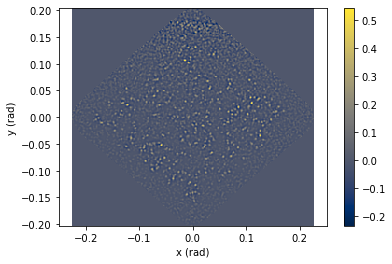

In [98]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
plt.xlabel('x (rad)')
plt.ylabel('y (rad)')
ax.axis('equal')

(-0.22575039922668377,
 0.2262898770398482,
 -0.20317234408792986,
 0.2034893716267495)

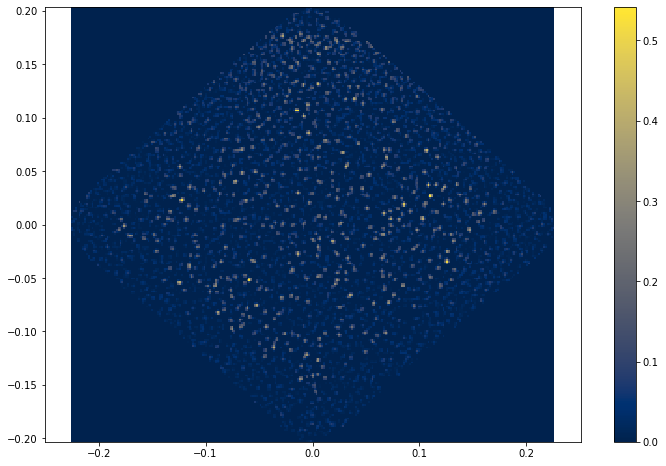

In [99]:
fig = plt.figure(1,figsize=(12,8))
ax = fig.add_subplot(111)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.colorbar(plot)
ax.axis('equal')

In [100]:
S0 = 0
cwt_map_thresh = np.copy(cwt_map[:,:,0])
thresh_map = (cwt_map_thresh > S0)
cwt_map_thresh[~thresh_map] = 0

In [101]:
popt = np.flip([6.56775576, -1.58598391,  0.06022358]) # PSF from psf_fitting notebook
energy_list, energy_centers = maps.generate_energy_bins_()
maps.psf_(energy_centers[16], popt)

0.0016966446813055014

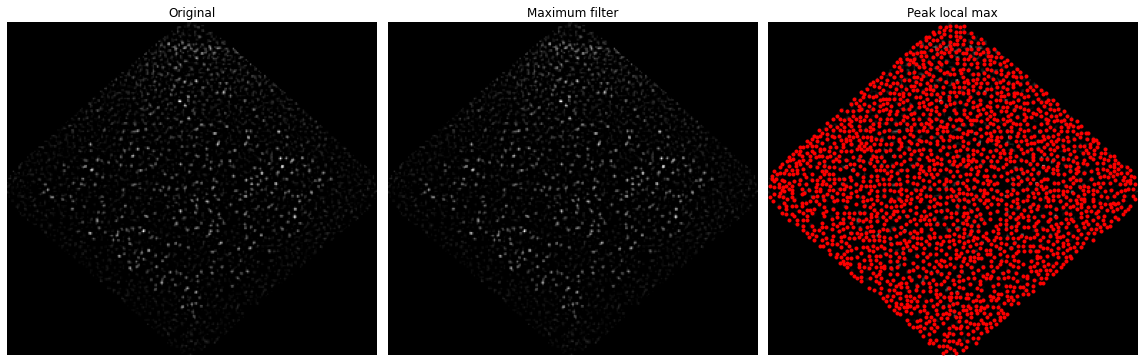

In [102]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# single a-value 
psf_degree = 0.17
psf_scale = psf_degree * np.pi / 180
grid_scale = 0.1 * np.pi / 180
N_pix_psf = 1

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(cwt_map_thresh, size=N_pix_psf, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(cwt_map_thresh, min_distance=N_pix_psf, 
                             threshold_abs = S0)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8*2, 6))
ax = axes.ravel()
ax[0].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')
ax[0].invert_yaxis()

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')
ax[1].invert_yaxis()

ax[2].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
# ax[2].plot(ps_approx[1], ps_approx[0], 'b.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
ax[2].invert_yaxis()

fig.tight_layout()

plt.show()

In [103]:
# load father pixels and edge
NSIDE = 4
NPIX = hp.nside2npix(NSIDE)
arr_edge_points = maps.healpix_edge_generator_(NSIDE = 4, step = 100)

# load point source locations
ps_loc_dir = bkgd_wps_dir 
events_loc = np.load(ps_loc_dir + 'ps_loc.npy', allow_pickle = True)
l_events_loc = events_loc[:,0]
b_events_loc = events_loc[:,1]

phi_events_loc = l_events_loc.copy()
phi_events_loc[phi_events_loc>np.pi] = phi_events_loc[phi_events_loc>np.pi]-2*np.pi

lon_events_loc = phi_events_loc + np.pi
lat_events_loc = b_events_loc

## group points into father pixels
grouped_loc_lon, grouped_loc_lat = maps.divide_data_into_groups_(lon_events_loc, lat_events_loc, arr_edge_points)

# load S0_list
S0_list = np.arange(0.001,1+0.001,0.001)
# log_S0_list = np.arange(-3,0+0.001,0.001)
# S0_list = 10**log_S0_list
N_S0 = len(S0_list)

In [104]:
# obtain grid within only the father pixel
arr_edge_points = projected_map['search_region_edge']
x_edge = arr_edge_points[:,0] ; y_edge = arr_edge_points[:,1]


Ny,Nx = mesh_bxby.shape[:-1]
grid_pix_flat = maps.find_points_inside_curve_(arr_b[:,0], arr_b[:,1], x_edge, y_edge, return_grid=True) # 2D array
grid_pix = grid_pix_flat.reshape((Ny,Nx))
grid_points = arr_b[grid_pix_flat,:]
N_grid = grid_points.shape[0]

# pre-allocate arrays of positive and negative detections
arr_fp = np.zeros((N_S0))
arr_tp = np.zeros((N_S0))
arr_fn = np.zeros((N_S0))
arr_tn = np.zeros((N_S0))

# load psf degree and grid scale
psf_degree = 0.17    # dependent on father pixel (should use maps.psf_ fct)
psf_scale = psf_degree * np.pi / 180
grid_scale = 0.1 * np.pi / 180
N_pix_psf = int(psf_scale / grid_scale)

# load point source locations
lon_events_loc_npix = grouped_loc_lon[npix]
lat_events_loc_npix = grouped_loc_lat[npix]

# project point source locations to father pixel
lon_c, lat_c = projected_map['center_coords']
r_loc = np.array(maps.tangent_plane_proj_(lat_events_loc_npix, lon_events_loc_npix, lat_c, lon_c))
N_ps = r_loc.shape[0]

for n_S0 in range(N_S0):
    S0 = S0_list[n_S0]

    # threshold the wavelet map
    cwt_map_thresh = np.copy(cwt_map[:,:,0])
    thresh_map = (cwt_map_thresh > S0)
    cwt_map_thresh[~thresh_map] = 0

    # identify point source finders with peak_local_max
    coordinates = peak_local_max(cwt_map_thresh, min_distance=N_pix_psf, 
                             threshold_abs = S0)

    # obtain positions of detections that are within the og father pixel
    nx = coordinates[:,1]
    ny = coordinates[:,0]

    arr_bx = 0.5 * (arr_bx_plot[:-1] + arr_bx_plot[1:])
    arr_by = 0.5 * (arr_by_plot[:-1] + arr_by_plot[1:])
    pos_x = arr_bx[nx]
    pos_y = arr_by[ny]

    x_in, y_in = maps.find_points_inside_curve_(pos_x, pos_y, x_edge, y_edge)
    detection_pos = np.stack((x_in, y_in), axis = -1)
    N_detect = len(x_in)

    # calculate minimum distances of detection grid points from point source
    relative_positions = r_loc[:,np.newaxis,:] - detection_pos
    distances_from_ps = np.linalg.norm(relative_positions, axis = -1)
    min_rel_pos = np.min(distances_from_ps, axis = 0)

    # threshold for grid point to be associated with point source (within \sigma_psf and \sigma_grid)
    thresh_dist = (min_rel_pos < np.sqrt(psf_scale**2. + grid_scale**2.) )
    min_rel_pos_thresh = min_rel_pos[thresh_dist] 

    # calculate positives and negatives
    tp = len(min_rel_pos_thresh) 
    fp = len(min_rel_pos) - len(min_rel_pos_thresh)
    fn = N_ps - tp
    tn = N_grid - tp - fp - fn

    # store into array
    arr_tp[n_S0] = tp
    arr_fp[n_S0] = fp
    arr_fn[n_S0] = fn
    arr_tn[n_S0] = tn

# calculate tprs and fprs
arr_tpr = arr_tp / (arr_tp + arr_fn)
arr_tpr[np.isnan(arr_tpr)] = 0
arr_fpr = arr_fp / (arr_fp + arr_tn)
arr_fpr[np.isnan(arr_fpr)] = 0

/het/p4/ramirez/envs/gcw2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'TPR')

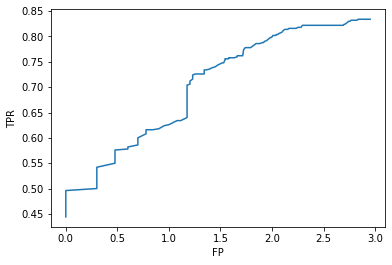

In [105]:
plt.plot(np.log10(arr_fp), arr_tpr)
plt.xlabel('FP')
plt.ylabel('TPR')

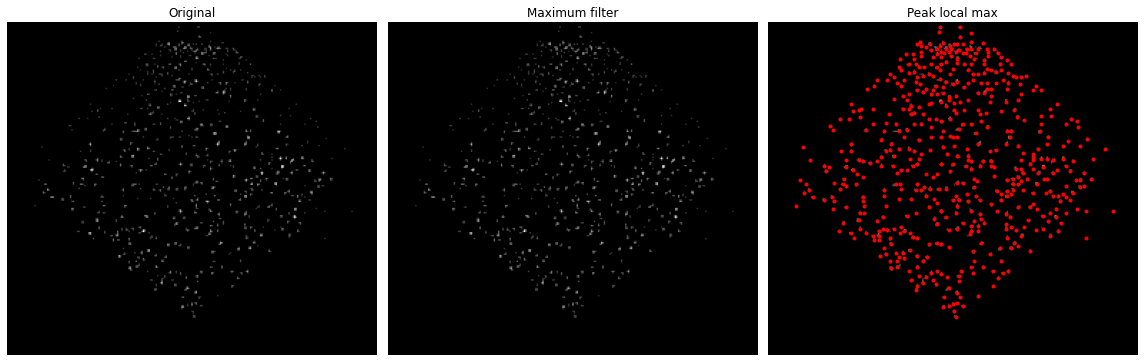

In [106]:
S0 = 0.1
cwt_map_thresh = np.copy(cwt_map[:,:,0])
thresh_map = (cwt_map_thresh > S0)
cwt_map_thresh[~thresh_map] = 0

from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# single a-value 
psf_degree = 0.17
psf_scale = psf_degree * np.pi / 180
grid_scale = 0.1 * np.pi / 180
N_pix_psf = 1

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(cwt_map_thresh, size=N_pix_psf, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(cwt_map_thresh, min_distance=N_pix_psf, 
                             threshold_abs = S0)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8*2, 6))
ax = axes.ravel()
ax[0].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')
ax[0].invert_yaxis()

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')
ax[1].invert_yaxis()

ax[2].imshow(cwt_map_thresh, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
# ax[2].plot(ps_approx[1], ps_approx[0], 'b.')
ax[2].axis('off')
ax[2].set_title('Peak local max')
ax[2].invert_yaxis()

fig.tight_layout()

plt.show()

In [107]:
nx = coordinates[:,1]
ny = coordinates[:,0]

pos_x = arr_bx[nx]
pos_y = arr_by[ny]

arr_edge_points = projected_map['search_region_edge']
x_edge = arr_edge_points[:,0] ; y_edge = arr_edge_points[:,1]
x_in, y_in = maps.find_points_inside_curve_(pos_x, pos_y, x_edge, y_edge)

In [108]:
cwt_map_thresh.shape

(233, 259)

(-0.22575039922668377,
 0.2262898770398482,
 -0.20317234408792986,
 0.2034893716267495)

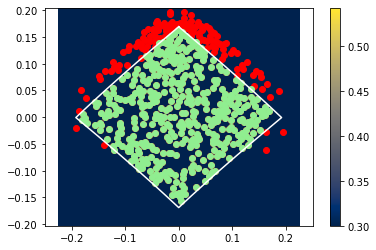

In [109]:
fig = plt.figure(1,figsize=(6,4))
ax = fig.add_subplot(111)



plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0.3, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.plot(x_edge, y_edge, c = 'white')
plt.scatter(pos_x, pos_y, c = 'r')
plt.scatter(x_in, y_in, c = 'lightgreen')
plt.colorbar(plot)
ax.axis('equal')

In [110]:
lon_c, lat_c = projected_map['center_coords']

In [111]:
r_ps = np.array([maps.inv_tangent_plane_proj_(x_in[n], y_in[n], lon_c, lat_c) for n in range(len(x_in))])

In [112]:
from astropy_healpix import HEALPix
NSIDE = 4
ahp = HEALPix(nside = NSIDE, order = 'ring')
lon_edge, lat_edge = ahp.boundaries_lonlat([npix], step = 100)

In [113]:
lon_edge = np.array(lon_edge[0,:]) ; lat_edge = np.array(lat_edge[0,:])

Text(0, 0.5, 'Latitude (rad)')

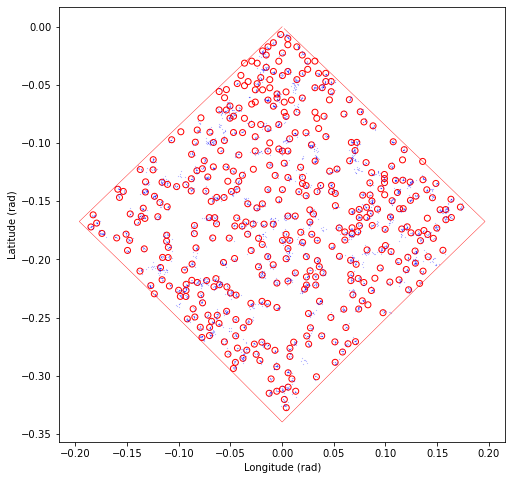

In [114]:
events_ps = np.load(map_dir + 'ps_map.npy', allow_pickle = True)
l_events_ps = events_ps[:,0]
b_events_ps = events_ps[:,1]

phi_events_ps = l_events_ps.copy()
phi_events_ps[phi_events_ps>np.pi] = phi_events_ps[phi_events_ps>np.pi]-2*np.pi

lon_events_ps = phi_events_ps + np.pi
lat_events_ps = b_events_ps

fig = plt.figure(1,figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.01, c = 'blue')
plt.xlabel('Longitude (rad)')
plt.ylabel('Latitude (rad)')

Text(0, 0.5, 'Latitude (rad)')

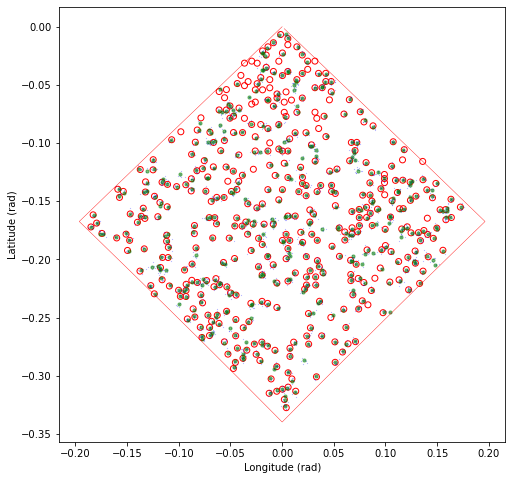

In [115]:
events_ps = np.load(map_dir + 'ps_map.npy', allow_pickle = True)
l_events_ps = events_ps[:,0]
b_events_ps = events_ps[:,1]

phi_events_ps = l_events_ps.copy()
phi_events_ps[phi_events_ps>np.pi] = phi_events_ps[phi_events_ps>np.pi]-2*np.pi

lon_events_ps = phi_events_ps + np.pi
lat_events_ps = b_events_ps

fig = plt.figure(1,figsize=(8,8))
ax = fig.add_subplot(111)

plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.01, c = 'blue')
plt.scatter(lon_events_loc - np.pi, lat_events_loc, c = 'green', s = 10, alpha = 0.5)
plt.xlabel('Longitude (rad)')
plt.ylabel('Latitude (rad)')

Text(0, 0.5, 'Latitude (rad)')

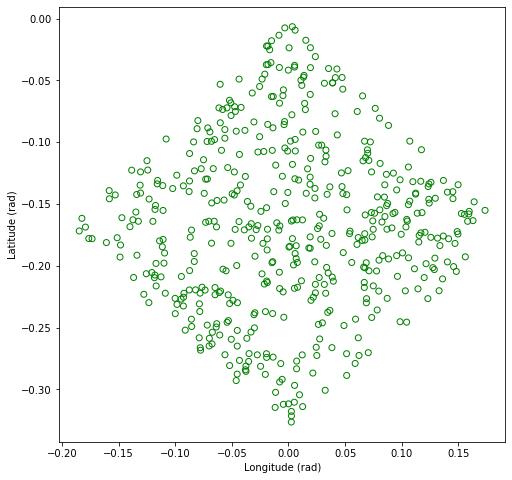

In [116]:
fig = plt.figure(1,figsize=(8,8))
ax = fig.add_subplot(111)

# plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
# plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
# plt.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.01, c = 'blue')
plt.scatter(lon_events_loc - np.pi, lat_events_loc, facecolors = 'none', edgecolors = 'g')
plt.xlabel('Longitude (rad)')
plt.ylabel('Latitude (rad)')

/het/p4/ramirez/envs/gcw2/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  if __name__ == '__main__':


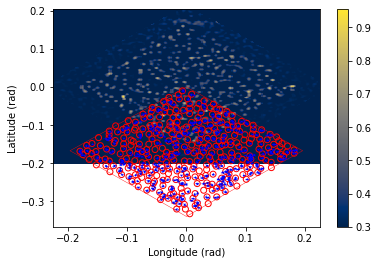

In [99]:
plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='cividis', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=0, 
                                                 vmax=np.max(cwt_map[:,:,0])))
plt.scatter(r_ps[:,0] - np.pi, r_ps[:,1], facecolors = 'none', edgecolors = 'r')
plt.plot(lon_edge - np.pi, lat_edge, lw = 0.4, c = 'red')
plt.scatter(lon_events_ps - np.pi, lat_events_ps, s = 0.01, c = 'blue')
plt.xlabel('Longitude (rad)')
plt.ylabel('Latitude (rad)')
plt.colorbar(plot)

In [100]:
r_ps.shape

(343, 2)

In [101]:
events_ps.shape

(14866, 4)

In [149]:
from scipy.stats import poisson

poisson.cdf(10,30)

2.2348775738450672e-05